# CS-GY 9223-D: Deep Learning Homework 2
Due on Friday, 12th March 2019, 11:55 PM

This homework can be done in pairs.

Write down the UNIs (NetIDs) of your group (if applicable)

Member 1: Hupo Tang, ht1073

Member 2: Name, NetID

In [64]:
import os
import numpy as np
import glob
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import SGD, RMSprop, Adam

# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, Lambda, Reshape, ZeroPadding2D
# from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.utils import to_categorical

import cv2
# import matplotlib.pylab as plt
# %matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [6]:
data_path = './'
TRAIN = './images_training_rev1/'
VALID = ''
TEST = './images_test_rev1/'
LABELS = './training_solutions_rev1.csv'

In [19]:
from random import shuffle
from scipy.misc import imresize
import csv

class data_loader:    
    """
    Creates a class for handling train/valid/test data paths,
    training labels and image IDs.
    Useful for switching between sample and full datasets.
    """
    def __init__(self, path):    
        self.path = path 
        self.train_path = TRAIN
        #self.val_path = path + "valid"
        self.test_path = TEST
        
        def get_paths(directory):
            return [f for f in os.listdir(directory)]
        
        self.training_images_paths = get_paths(self.train_path)
        # self.validation_images_paths = get_paths(self.val_path)
        self.test_images_paths = get_paths(self.test_path)    
        
        def get_all_solutions():
        # Import solutions file and load into self.solutions
            all_solutions = {}
            # /'training_solutions_rev1.csv'
            with open(LABELS, 'r') as f:
                reader = csv.reader(f, delimiter=",")
                next(reader)
                for i, line in enumerate(reader):
                    all_solutions[line[0]] = [float(x) for x in line[1:]]
            return all_solutions
        
        self.all_solutions = get_all_solutions()

    def get_id(self,fname):
        return fname.replace(".jpg","").replace("data","")
        
    def find_label(self,val):
        return self.all_solutions[val]

def process_images(paths):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    """
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        img = cv2.imread(path).T
        img = img[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res
        arr[c] = img
    return arr

def BatchGenerator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)


In [20]:
def rotate(img):
    return np.rot90(img,axes=(1,2))

def flip(img):
    return np.flip(img, axis=1)            

def process_withaug(paths,aug=0):
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        raw_img = cv2.imread(path).T
        if not aug:
            img=raw_img
        else:
            auger={1:rotate,2:flip}.get(aug)
            img=auger(raw_img)
        img = img[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res
        arr[c] = img
    return arr

def BatchGenerator_withaug(getter):
    while 1:
        for f in getter.training_images_paths:
            for aug in {0,1,2}:
                X_train = process_withaug([getter.train_path + '/' + fname for fname in [f]], aug)
                id_ = getter.get_id(f)
                y_train = np.array(getter.find_label(id_))
                y_train = np.reshape(y_train,(1,37))
                yield (X_train, y_train)


In [8]:
fetcher = data_loader(data_path)

In [9]:
def ConvBlock(layers, model, filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Convolution2D(filters, 3, 3, activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D((1,1), strides=(2,2)))

def FCBlock(model):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(3,106,106)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model


In [10]:
# Compile 
optimizer = RMSprop(lr=1e-6)
model = VGG_16()
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [30]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='./tmp/weights.hdf5', verbose=1, save_best_only=True)

batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)

history = LossHistory()

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [12]:
# VGG16 with no augmentation

hist = model.fit_generator(BatchGenerator(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                   )

Epoch 1/50
 - 67s - loss: 0.0969
Epoch 2/50
 - 58s - loss: 0.0324
Epoch 3/50
 - 60s - loss: 0.0314
Epoch 4/50
 - 56s - loss: 0.0310
Epoch 5/50
 - 61s - loss: 0.0299
Epoch 6/50
 - 57s - loss: 0.0292
Epoch 7/50
 - 60s - loss: 0.0292
Epoch 8/50
 - 63s - loss: 0.0288
Epoch 9/50
 - 61s - loss: 0.0284
Epoch 10/50
 - 56s - loss: 0.0289
Epoch 11/50
 - 70s - loss: 0.0281
Epoch 12/50
 - 67s - loss: 0.0279
Epoch 13/50
 - 71s - loss: 0.0279
Epoch 14/50
 - 63s - loss: 0.0280
Epoch 15/50
 - 62s - loss: 0.0278
Epoch 16/50
 - 65s - loss: 0.0271
Epoch 17/50
 - 63s - loss: 0.0269
Epoch 18/50
 - 60s - loss: 0.0277
Epoch 19/50
 - 64s - loss: 0.0267
Epoch 20/50
 - 61s - loss: 0.0265
Epoch 21/50
 - 62s - loss: 0.0265
Epoch 22/50
 - 60s - loss: 0.0266
Epoch 23/50
 - 60s - loss: 0.0273
Epoch 24/50
 - 61s - loss: 0.0264
Epoch 25/50
 - 67s - loss: 0.0256
Epoch 26/50
 - 64s - loss: 0.0250
Epoch 27/50
 - 59s - loss: 0.0246
Epoch 28/50
 - 63s - loss: 0.0242
Epoch 29/50
 - 67s - loss: 0.0243
Epoch 30/50
 - 58s - lo

In [22]:
# VGG16 with augmentation

hist_aug = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*3, 
                    nb_epoch=25,
                    verbose=2,
                    callbacks=[hist,checkpointer,early_stopping],
                   )

Epoch 1/25
 - 117s - loss: 0.0219
Epoch 2/25
 - 117s - loss: 0.0211
Epoch 3/25
 - 118s - loss: 0.0205
Epoch 4/25
 - 118s - loss: 0.0199
Epoch 5/25
 - 119s - loss: 0.0199
Epoch 6/25
 - 125s - loss: 0.0201
Epoch 7/25
 - 120s - loss: 0.0200
Epoch 8/25
 - 117s - loss: 0.0198
Epoch 9/25
 - 118s - loss: 0.0195
Epoch 10/25
 - 124s - loss: 0.0197
Epoch 11/25
 - 130s - loss: 0.0190
Epoch 12/25
 - 117s - loss: 0.0187
Epoch 13/25
 - 117s - loss: 0.0186
Epoch 14/25
 - 117s - loss: 0.0186
Epoch 15/25
 - 117s - loss: 0.0187
Epoch 16/25
 - 117s - loss: 0.0183
Epoch 17/25
 - 117s - loss: 0.0176
Epoch 18/25
 - 117s - loss: 0.0185
Epoch 19/25
 - 117s - loss: 0.0176
Epoch 20/25
 - 117s - loss: 0.0175
Epoch 21/25
 - 117s - loss: 0.0174
Epoch 22/25
 - 117s - loss: 0.0178
Epoch 23/25
 - 117s - loss: 0.0178
Epoch 24/25
 - 117s - loss: 0.0173
Epoch 25/25
 - 117s - loss: 0.0174


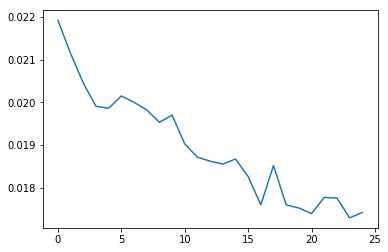

In [29]:
plt.plot(list(hist_aug.history.values())[0])

In [11]:
len(fetcher.training_images_paths)

61578

In [31]:
#Aug with larger epochs

hist_aug2 = model.fit_generator(BatchGenerator_withaug(fetcher),
                    samples_per_epoch=steps_to_take*3, 
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[hist,checkpointer,early_stopping],
                   )

Epoch 1/50
 - 116s - loss: 0.0173
Epoch 2/50
 - 116s - loss: 0.0170
Epoch 3/50
 - 116s - loss: 0.0163
Epoch 4/50
 - 116s - loss: 0.0166
Epoch 5/50
 - 116s - loss: 0.0168
Epoch 6/50
 - 116s - loss: 0.0169
Epoch 7/50
 - 116s - loss: 0.0168
Epoch 8/50
 - 117s - loss: 0.0165
Epoch 9/50
 - 116s - loss: 0.0164
Epoch 10/50
 - 116s - loss: 0.0167
Epoch 11/50
 - 116s - loss: 0.0163
Epoch 12/50
 - 116s - loss: 0.0161
Epoch 13/50
 - 116s - loss: 0.0164
Epoch 14/50
 - 116s - loss: 0.0164
Epoch 15/50
 - 116s - loss: 0.0165
Epoch 16/50
 - 116s - loss: 0.0160
Epoch 17/50
 - 116s - loss: 0.0155
Epoch 18/50
 - 116s - loss: 0.0164
Epoch 19/50
 - 116s - loss: 0.0156
Epoch 20/50
 - 116s - loss: 0.0158
Epoch 21/50
 - 116s - loss: 0.0155
Epoch 22/50
 - 116s - loss: 0.0162
Epoch 23/50
 - 116s - loss: 0.0161
Epoch 24/50
 - 116s - loss: 0.0156
Epoch 25/50
 - 116s - loss: 0.0158
Epoch 26/50
 - 118s - loss: 0.0153
Epoch 27/50
 - 122s - loss: 0.0158
Epoch 28/50
 - 133s - loss: 0.0155
Epoch 29/50
 - 123s - loss: 0

In [32]:
model.save_weights('./tmp/weights.hdf5')

In [35]:
def testGenerator(getter):
    while 1:
        for f in getter.test_images_paths:
            X_test = process_images([getter.test_path + '/' + fname for fname in [f]])
            yield (X_test)


In [36]:
predictions = model.predict_generator(testGenerator(fetcher),
                       val_samples = len(fetcher.test_images_paths),
                        max_q_size = 32)

In [37]:
predictions.shape

(600, 37)

In [ ]:
header = open('all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_1.csv','w') as outfile:
    outfile.write(header)
    for i in range(len(fetcher.test_images_paths)):
        id_ = (fetcher.get_id(fetcher.test_images_paths[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")

In [58]:
class LeNet(Model):
    def __init__(self, input_shape=(3, 106, 106), num_classes=37):
        # super(LeNet, self).__init__(name="LeNet")
        self.num_classes = num_classes
        ''' 定义要用到的层 layers '''
        # 输入层
        img_input = Input(shape=input_shape)

        # Conv => ReLu => Pool
        x = Conv2D(filters=20, kernel_size=5, padding="same", activation="relu" ,name='block1_conv1')(img_input)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool')(x)
        # Conv => ReLu => Pool
        x = Conv2D(filters=50, kernel_size=5, padding="same", activation="relu", name='block1_conv2')(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same", name='block1_poo2')(x)
        # 压成一维
        x = Flatten(name='flatten')(x)
        # 全连接层
        x = Dense(units=500, activation="relu", name="f1")(x)
        # softmax分类器
        x = Dense(units=num_classes, activation="softmax", name="prediction")(x)

        # 调用Model类的Model(input, output, name="***")构造方法
        super(LeNet, self).__init__(img_input, x, name="LeNet")

    def call(self, inputs):
        # 前向传播计算
        # 使用在__init__方法中定义的层
        return self.output(inputs)


In [44]:
input_shape = (3,106,106)
classes = 37

NB_EPOCH = 20
BATCH_SIZE = 64
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT = 0.2
IMG_ROWS, IMG_COLS = 106, 106
NB_CLASSES = 37
INPUT_SHAPE = (3, IMG_ROWS, IMG_COLS)

In [60]:
def X_generator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            yield X_train
            
def y_generator(getter):
    while 1:
        for f in getter.training_images_paths:
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train, (1,37))
            yield y_train

In [59]:
LeModel = LeNet(INPUT_SHAPE, NB_CLASSES)
LeModel.summary()

LeModel.compile(loss="categorical_crossentropy", optimizer=tf.train.RMSPropOptimizer(learning_rate=0.0001),
              metrics=["accuracy"])

history = LeModel.fit(x=X_generator(fetcher), y=X_generator, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE,
                    validation_split=VALIDATION_SPLIT)

NameError: name 'y' is not defined